# Probabilistic Models – Spring 2021
## Exercise Session 6
March 3rd 16.15

<span style="color:red">**Carmen Díez**</span>

### Instructions
Make sure the notebook produces correct results when ran sequentially starting from the first cell. You can ensure this by clearing all outputs (`Edit > Clear All Outputs`), running all cells (`Run > Run All Cells`), and finally correcting any errors.

To get points:
1. Submit your answers to the automatically checked Moodle test. 
 - You have 5 tries on the test: the highest obtained score will be taken into account.
 - For numerical questions the tolerance is $1\cdot10^{-4}$.
2. Submit this notebook containing your derivations to Moodle.

## Exercise 1
***

`jkl` is a somewhat standard file format for local scores. The first line in a `jkl`-file states the number of variables/nodes, and the rest of the file is divided into node specific sections. The first line in a section states the variable name and the number of local scores to follow. Each local score is followed by the number of parents for the local score and the parent variables themselves. In the section for variable 0 the line `-193.80 0` thus corresponds to the local score $f(0, \emptyset)$; the line `-193.42 2 1 2` corresponds to the local score $f(0, \{ 1, 2\})$, etc.

Consider the following local scores:

In [1]:
!cat data/1_fix.jkl

4
0 8
-193.80021345773184 0 
-197.16851527924672 1 1
-188.8375185956392 1 2
-189.89041764309678 1 3
-193.4201332025088 2 1 2
-213.92449082704218 2 1 3
-181.94961348240275 2 2 3
-212.20350455559912 3 1 2 3
1 8
-181.3940093476881 0 
-184.76231116920297 1 0
-186.30305389009453 1 2
-161.58080460560382 1 3
-190.88566849696412 2 0 2
-185.6148777895492 2 0 3
-174.47344794910612 2 2 3
-204.7273390223025 3 0 2 3
2 8
-182.99314409357032 0 
-178.0304492314777 1 0
-187.90218863597676 1 1
-151.04672436005933 1 3
-184.15380655923883 2 0 1
-143.1059201993653 2 0 3
-163.93936770356163 2 1 3
-162.21838143211858 3 0 1 3
3 8
-169.22877645649714 0 
-165.31898064186208 1 0
-149.41557171441286 1 1
-137.28235672298615 1 2
-166.17154726220832 2 0 1
-130.3944516097497 2 0 2
-125.45275078199774 2 1 2
-144.23612213508807 3 0 1 2


Use dynamic programming to find (one of) the highest scoring DAG(s) (i.e. maximizing the marginal likelihood or the global BDeu score).

Report the obtained score for the DAG.

### Solution
Highest scoring DAG with dynamic programming: having an specific causal order calculate the DAG that maximizes the score. We know the potential parents and we take the option with those parents (or less parents) that maximizes the score. We try all possible causal orders (permutations of the number of nodes).

In [2]:
import pandas as pd 
import numpy as np
from itertools import permutations
import graphviz

In [3]:
def append_to_df(node, local_score, parents):
    return df.append({'node': node, 'local_score': local_score, 'parents': parents}, ignore_index=True)

In [4]:
def best_network(causal_order):
    best_graph = pd.DataFrame()
    causal_order_str = [str(n) for n in causal_order]
    
    for i in range(n_nodes):
        df_node = df[df['node'] == causal_order_str[i]]
        potential_parents = causal_order_str[:i]
        
        n_local = len(df_node.index)
        
        #we save the possible settings with the given potential parents
        valid = [True]*n_local
        for j in range(n_local):
            ps = df_node['parents'].iloc[j]
            for k in range(len(ps)):
                if ps[k] not in potential_parents:
                    valid[j] = False
                    break

        df_valid = df_node[valid]
        
        valid_max = df_valid['local_score'].max()
        row_max = df_valid[df_valid['local_score'] == valid_max]
        best_graph = best_graph.append(row_max, ignore_index=True)
    return best_graph

In [5]:
#reading the file
cols = ['node', 'local_score', 'parents']
df = pd.DataFrame(columns = cols)

f = open('data/1_fix.jkl')
n_nodes = int(f.readline())
for _ in range(n_nodes):
    node_and_n_local = f.readline().split()
    node = node_and_n_local[0]
    n_local = int(node_and_n_local[1])
    for _ in range(n_local):
        local = f.readline().split()
        local_score = float(local[0])
        n_parents = int(local[1])
        if n_parents==0:
            parents = ''
        else:
            parents = []
            for i in range(n_parents):
                parents += [local[2+i]]
            parents = "".join(parents)
        
        df = append_to_df(node, local_score, parents)

In [6]:
#all possible causal orders
perms = permutations([0,1,2,3])
orders = list(perms)

#best network for each possible causal order
best_networks = []
for causal_order in orders:
    best_networks.append(best_network(causal_order))

#scores for each network
scores = [df['local_score'].sum() for df in best_networks]

# find id of maximum
id_max = np.argmax(scores)

print('Maximum Score:', scores[id_max] )
best_networks[id_max]

Maximum Score: -663.805918904563


,node,local_score,parents
0,0,-193.800213,
1,2,-178.030449,0
2,3,-130.394452,02
3,1,-161.580805,3


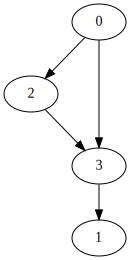

In [7]:
g = graphviz.Digraph(engine='dot', graph_attr={'rankdir':'TB', 'size':'20', 'nodesep':'1'})

g.node("0")
g.node("1")
g.node("2")
g.node("3")

g.edge("0","2")
g.edge("0","3")
g.edge("2","3")
g.edge("3","1")

g

## Exercise 2
***

Given the local scores above, find an optimal tree structure using the Chow-Liu algorithm.

Report the obtained score for the DAG.

### Solution
Chow-liu algorithm: 
1. Initialize a complete undirected weighted graph G on N with edge weights $w_{ij}=f(i,j)-f(i,\emptyset)=f(j,i)-f(j,\emptyset)$.
2. Find a maximum (weight) spanning tree G' of G (using Kruskal algorith, for example).
3. Choose an arbitrary node as a root and orient all edges in G' away from it.

In [8]:
def f(node, parents):
    if type(parents) == list:
        parents = ''.join([str(n) for n in parents])
    if type(node) != str:
        node = str(node)
    return df[(df['node']==node) & (df['parents']==parents)]['local_score'].item()

weights = dict()
for i in range(n_nodes):
    weights[i] = dict()
    for j in range(n_nodes):
        if i!=j and i<j:
            weights[i][j] = f(i, [j]) - f(i, [])
            print(i, '-', j, ':', weights[i][j])

0 - 1 : -3.3683018215148763
0 - 2 : 4.962694862092633
0 - 3 : 3.9097958146350607
1 - 2 : -4.909044542406434
1 - 3 : 19.81320474208428
2 - 3 : 31.946419733510993


We perform Kruskal with weights obtained. We choose the edges with the highest scores without getting cycles:

1. **2 - 3:** 31.946419733510993
2. **1 - 3:** 19.81320474208428
3. **0 - 2:** 4.962694862092633

We have connected all nodes. We choose, for example, 0 as root and we get the following tree: **0 -> 2 -> 3 -> 1**. Then, we calculate the tree's score.

In [9]:
score = f(0,'') + f(2,'0') + f(3,'2') + f(1, '3')
print('Score:', score)

Score: -670.6938240177994


## Exercise 3
***

For the local scores above, run basic greedy hill climbing starting from the empty network until the score cannot be improved by a local operation. Do not perform any zero gain operations and make sure not to form cyclic networks.

Report the obtained score for the DAG.

### Solution
Greedy Hill climbing algorithm:

Start with no edges and then perform operations that makes the score better:

* Add an edge.
* Delete an edge.
* Reverse an edge.

At each search step, we find the best neighbor and move to it. The gain is the difference between the new DAG and the score before.

In [10]:
def f(node, parents):
    if type(parents) == list:
        parents = ''.join([str(n) for n in parents])
    if type(node) != str:
        node = str(node)
    return df[(df['node']==node) & (df['parents']==parents)]['local_score'].item()

#score empty graph
score = f(0,'') + f(1,'') + f(2,'') + f(3,'')
print('Score 0 (empty):', score)

#we start with edge 2->3, gain = f(3,[2]) - f(3,[]) = weights[2][3]
score = score + weights[2][3]
print('Score 1:', score)

#adding the next edge 3->1, biggest weight (reversing or deleting worsens or leaves the same the score)
score = score + weights[1][3]
print('Score 2:', score)

#right now 2->3->1, 0
# f(0,'') + f(1,'3') + f(2,'') + f(3,'2') 
print('\n  1st decision:')
gain_add01 = f(0,'') + f(1,'03') + f(2,'') + f(3,'2')  - score
print('add 0->1: ', gain_add01)
gain_add02 = f(0,'') + f(1,'3') + f(2,'0') + f(3,'2')  - score
print('add 0->2: ', gain_add02)
gain_add03 = f(0,'') + f(1,'3') + f(2,'') + f(3,'02')  - score
print('add 0->3: ', gain_add03)

gain_add10 = f(0,'1') + f(1,'3') + f(2,'') + f(3,'2')  - score
print('add 1->0: ', gain_add10)
#1->2 makes cycle
gain_rev13 = f(0,'') + f(1,'') + f(2,'') + f(3,'12')  - score
print('rev 1->3: ', gain_rev13) #rev to that position

gain_add20 = f(0,'2') + f(1,'3') + f(2,'') + f(3,'2')  - score
print('add 2->0: ', gain_add20)
gain_add21 = f(0,'') + f(1,'23') + f(2,'') + f(3,'2')  - score
print('add 2->1: ', gain_add21)
gain_del23 = f(0,'') + f(1,'3') + f(2,'') + f(3,'')  - score
print('del 2->3: ', gain_del23)

gain_add30 = f(0,'3') + f(1,'3') + f(2,'') + f(3,'2')  - score
print('add 3->0: ', gain_add30)
gain_del31 = f(0,'') + f(1,'') + f(2,'') + f(3,'2')  - score
print('del 3->1: ', gain_del31)
gain_rev32 = f(0,'') + f(1,'3') + f(2,'3') + f(3,'')  - score
print('rev 3->2: ', gain_rev32)

score = score + gain_add03
print('Score 3 adding 0->3:', score)

#right now 2->3->1, and 0->3
# f(0,'') + f(1,'3') + f(2,'') + f(3,'02') 
print('\n  2nd decision:')
gain_add01 = f(0,'') + f(1,'03') + f(2,'') + f(3,'02') - score
print('add 0->1: ', gain_add01)
gain_add02 = f(0,'') + f(1,'3') + f(2,'0') + f(3,'02') - score
print('add 0->2: ', gain_add02)
gain_del03 = f(0,'') + f(1,'3') + f(2,'') + f(3,'2') - score
print('del 0->3: ', gain_del03)

#1->0 cycle
#1->2 cycle
gain_rev13 = f(0,'') + f(1,'') + f(2,'') + f(3,'012') - score
print('rev 1->3: ', gain_rev13) #rev to that position

gain_add20 = f(0,'2') + f(1,'3') + f(2,'') + f(3,'02') - score
print('add 2->0: ', gain_add20)
gain_add21 = f(0,'') + f(1,'23') + f(2,'') + f(3,'02') - score
print('add 2->1: ', gain_add21)
gain_del23 = f(0,'') + f(1,'3') + f(2,'') + f(3,'0') - score
print('del 2->3: ', gain_del23)

gain_rev30 = f(0,'3') + f(1,'3') + f(2,'') + f(3,'2')  - score
print('rev 3->0: ', gain_rev30)
gain_del31 = f(0,'') + f(1,'') + f(2,'') + f(3,'02')  - score
print('del 3->1: ', gain_del31)
gain_rev32 = f(0,'') + f(1,'3') + f(2,'3') + f(3,'0')  - score
print('rev 3->2: ', gain_rev32)

score = score + gain_add02
print('Score 4 adding 0->2:', score)

#right now 0->2->3->1, and 0->3
# f(0,'') + f(1,'3') + f(2,'0') + f(3,'02')
print('\n  3rd decision:')
gain_add01 = f(0,'') + f(1,'03') + f(2,'0') + f(3,'02') - score
print('add 0->1: ', gain_add01)
gain_del02 = f(0,'') + f(1,'3') + f(2,'') + f(3,'02') - score
print('del 0->2: ', gain_del02)
gain_del03 = f(0,'') + f(1,'3') + f(2,'0') + f(3,'2') - score
print('del 0->3: ', gain_del03)

#1->0 cycle
#1->2 cycle
gain_rev13 = f(0,'') + f(1,'') + f(2,'0') + f(3,'012') - score
print('rev 1->3: ', gain_rev13) #rev to that position

gain_rev20 = f(0,'2') + f(1,'3') + f(2,'') + f(3,'02') - score
print('rev 2->0: ', gain_rev20)
gain_add21 = f(0,'') + f(1,'23') + f(2,'0') + f(3,'02') - score
print('add 2->1: ', gain_add21)
gain_del23 = f(0,'') + f(1,'3') + f(2,'0') + f(3,'0') - score
print('del 2->3: ', gain_del23)

gain_rev30 = f(0,'3') + f(1,'3') + f(2,'0') + f(3,'2')  - score
print('rev 3->0: ', gain_rev30)
gain_del31 = f(0,'') + f(1,'') + f(2,'0') + f(3,'02')  - score
print('del 3->1: ', gain_del31)
gain_rev32 = f(0,'') + f(1,'3') + f(2,'03') + f(3,'0')  - score
print('rev 3->2: ', gain_rev32)

print('No more decisions as all are non positive. The final score is:', score)
print('Final DAG: 0->2->3->1, and 0->3')

Score 0 (empty): -727.4161433554874
Score 1: -695.4697236219764
Score 2: -675.6565188798921

  1st decision:
add 0->1:  -24.034073183945452
add 0->2:  4.96269486209269
add 0->3:  6.887905113236457
add 1->0:  -3.3683018215148195
rev 1->3:  -7.983598801095809
add 2->0:  4.96269486209269
add 2->1:  -12.8926433435023
del 2->3:  -31.946419733510993
add 3->0:  3.909795814635004
del 3->1:  -19.81320474208428
rev 3->2:  0.0
Score 3 adding 0->3: -668.7686137666557

  2nd decision:
add 0->1:  -24.034073183945452
add 0->2:  4.96269486209269
del 0->3:  -6.887905113236457
rev 1->3:  -33.65487526742265
add 2->0:  4.96269486209269
add 2->1:  -12.8926433435023
del 2->3:  -34.924529032112446
rev 3->0:  -2.978109298601453
del 3->1:  -19.81320474208428
rev 3->2:  -2.978109298601453
Score 4 adding 0->2: -663.805918904563

  3rd decision:
add 0->1:  -24.034073183945452
del 0->2:  -4.96269486209269
del 0->3:  -6.887905113236457
rev 1->3:  -33.65487526742265
rev 2->0:  0.0
add 2->1:  -12.892643343502414
del 

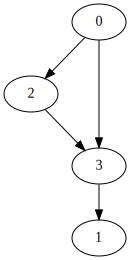

In [11]:
g = graphviz.Digraph(engine='dot', graph_attr={'rankdir':'TB', 'size':'20', 'nodesep':'1'})

g.node("0")
g.node("1")
g.node("2")
g.node("3")

g.edge("0","2")
g.edge("0","3")
g.edge("2","3")
g.edge("3","1")

g

## Exercise 4
***

When finding a highest scoring DAG over a set of local scores, one can reduce the size of the problem by pruning (i.e., omitting) any local scores $f(X_i, Q)$ for which there is another local score $f(X_i, P)$ such that  $f(X_i, P) > f(X_i, Q)$ and $P \subset Q$.  Prove that this is correct, i.e. show that $X_i$ does not have parent set $Q$ in a highest scoring DAG if there is another parent set $P$ such that $f(X_i, P) > f(X_i, Q)$ and $P \subset Q$.

### Solution

Using exact structure discovery we maximize the marginal likelihoods, obtaining the highest scoring DAG. W.l.o.g. we let the nodes have the following causal order: $\{X_1, X_2, ..., X_n\}$. Then, for any $X_i$ we can have the following parents' sets: $P \subset Q \subset \{X_1, X_2, ..., X_{i-1}\}$ with $X_i$, $P$ and $Q$ as in the text above. The algorithm will choose then $f(X_i, P)$ over $f(X_i, Q)$ as its a higher score. $\square$

## Exercise 5
***

Causal effects $P(Y|do(X=x))$ denote probability distributions over Y that result when $X$ is forced to some value $x$ (instead of observing that value). For (causal) Bayesian networks, causal effects can be calculated by taking the BN factorization and deleting the CPD factors for the intervened nodes (this is equivalent to deleting edges in the graph because if a variable is forced to a value it is no longer influenced by its parents), and then summing out variables $V\setminus \{X,Y\}$. Show  that equalities  $P(E|do(C=T))=P(E|C=T)$, $P(A|do(B=F))=P(A)$, $P(E|do(A=T))=P(E|A=T)$ apply in the following network.

![](6.5.svg)

In [12]:
!for v in {A..E}; do echo "CPT for node "$v; cat "data/cpt"$v".tsv"; echo ""; done

CPT for node {A..E}
cat: data/cpt{A..E}.tsv: No such file or directory



### Solution
For each case we delete the edges that come into the do variable and set P(variable=x)=1.

1. $P(E|do(C=T))=P(E|C=T)$?
    1. Delete edge $A$->$C$.
    2. $P(C=T)=1$.
    3. $E$ still depends on $C$ and is d-separated from the others by $D$<-$C$->$E$: it holds.

2. $P(A|do(B=F))=P(A)$?
    1. Delete edge $A$->$B$.
    2. $P(B=F)=1$.
    3. $A$ doesn't depend on $B$ (actually on none): it holds.
 
3. $P(E|do(A=T))=P(E|A=T)$?
    1. Delete no edges.
    2. $P(A=T)=1$.
    3. The graph stays the same: it holds.

## Exercise 6
***

Using the above network and explanation, calculate the causal effect $P(D|do(B=T))$. Show that it does not equal to $P(D)$ or $P(D|B=T)$.

Report:
- $P(D=T|do(B=T))$.
- $P(D=T)$.
- $P(D=T|B=T)$.

### Solution

We can calculate the different probabilities using message passing constructing an elimination tree:

In [13]:
def ini():
    #saving data to have it in week 4 format
    pA = pd.read_csv('data/cptA.tsv', sep ='\t' )
    pB = pd.read_csv('data/cptB.tsv', sep ='\t' )
    pC = pd.read_csv('data/cptC.tsv', sep ='\t' )
    pD = pd.read_csv('data/cptD.tsv', sep ='\t' )
    pE = pd.read_csv('data/cptE.tsv', sep ='\t' )

    fA = pA.melt(var_name = 'A', value_name = 'fA')
    fA['A'] = 1* (fA['A']=='True')
    fB = pB.melt(id_vars = 'A', var_name = 'B', value_name = 'fB')
    fB['B'] = 1* (fB['B']=='True')
    fC = pC.melt(id_vars = 'A', var_name = 'C', value_name = 'fC')
    fC['C'] = 1* (fC['C']=='True')
    fD = pD.melt(id_vars = ['B','C'], var_name = 'D', value_name = 'fD')
    fD['D'] = 1* (fD['D']=='True')
    fE = pE.melt(id_vars = 'C', var_name = 'E', value_name = 'fE')
    fE['E'] = 1* (fE['E']=='True')
    f = {'A':fA, 'B':fB, 'C':fC, 'D':fD, 'E':fE}
    return f

#Functions logic as in week 4 ex3 for message passing
def multPass(f1, f2):   
    nodes = np.unique(list(f1.columns[:-1]) + list(f2.columns[:-1])).tolist()
    col1 = f1.columns[-1]
    col2 = f2.columns[-1]
    
    fres = f1.merge(f2, how='left')
    fres[col1] = fres[col1]*fres[col2]
    fres = fres.drop(columns = col2)
    
    return fres[nodes+[col1]]

def sumOutPass(f1, V): #take V out
    if len(V)==0:
        return f1
    cols = f1.columns[:-1]
    colsOut = list(cols[[node not in V for node in cols]])
    fres = f1.groupby(colsOut, as_index=False).sum().drop(columns = V)
    return fres 

def projPass(f1, V): #stay with V only
    V = list(set(f1.columns[:-1]).difference(set(V)))
    return sumOutPass(f1, V)

We use the following elimination tree (similar to the one from week 4):

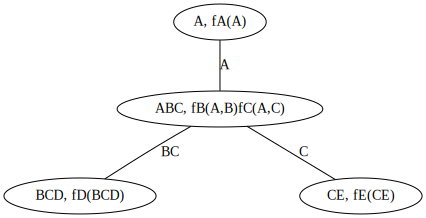

In [14]:
import graphviz

g = graphviz.Graph(engine='dot', 
                   graph_attr={'rankdir':'TB', 
                               'size':'7', 'nodesep':'2'})

g.node("A, fA(A)")
g.node("ABC, fB(A,B)fC(A,C)")
g.node("BCD, fD(BCD)")
g.node("CE, fE(CE)")

g.edge("A, fA(A)", "ABC, fB(A,B)fC(A,C)", label="A")
g.edge("ABC, fB(A,B)fC(A,C)", "BCD, fD(BCD)", label="BC")
g.edge("ABC, fB(A,B)fC(A,C)", "CE, fE(CE)", label="C")

g

We find $P(B,C,D)=\phi_3 * M_{23}$ and then $P(D)=$proj$(P(B,C,D), D)$ and $P(D|B)=\frac{P(B,D)}{P(B)}$.

In [15]:
# Message passing
# Initiate 
f = ini()
phi1 = f['A']
phi2 = multPass(f['B'], f['C'])
phi3 = f['D']
phi4 = f['E']

# Pull messages towards root
M12 = projPass(phi1, ['A'])
M32 = projPass(phi3, ['B','C'])
M42 = projPass(phi4, ['C'])

# Push messages away
# M32 and M42 are the identity so we dont multiply them
M21 = projPass(phi2, ['A']) #no need M32 and M42
M23 = projPass(multPass(phi2, M12), ['B','C']) #no need M42
M24 = projPass(multPass(phi2, M12), ['C']) #no need M32

pBCD = multPass(phi3, M23)  
pBD = sumOutPass(pBCD, 'C')
pB = sumOutPass(pBD, 'D')
pD = projPass(pBCD, 'D')
      
# Conditional probability 
pBCondD = pBD.merge(pB, on = 'B')
pBCondD['fD'] = pBCondD['fD_x']/pBCondD['fD_y']
pBCondD = pBCondD.drop(columns = ['fD_x','fD_y'])

print(pBCondD)
print()
print(pD)

   B  D        fD
0  0  0  0.575385
1  0  1  0.424615
2  1  0  0.075909
3  1  1  0.924091

   D      fD
0  0  0.4655
1  1  0.5345


In [16]:
#modifying probability P(B=True)=1
f['B']['fB'] = np.where(f['B']['B']==1, 1.0,0.0)
f['B']

#same calculations...
phi1 = f['A']
phi2 = multPass(f['B'], f['C'])
phi3 = f['D']
phi4 = f['E']

# Pull messages towards root
M12 = projPass(phi1, ['A'])
M32 = projPass(phi3, ['B','C'])
M42 = projPass(phi4, ['C'])

# Push messages away
# M32 and M42 are the identity so we dont multiply them
M21 = projPass(phi2, ['A']) #no need M32 and M42
M23 = projPass(multPass(phi2, M12), ['B','C']) #no need M42
M24 = projPass(multPass(phi2, M12), ['C']) #no need M32

pBCD = multPass(phi3, M23)  
pBD = sumOutPass(pBCD, 'C')
pB = sumOutPass(pBD, 'D')
pD = projPass(pBCD, 'D')
      
# Conditional probability 
pBCondD = pBD.merge(pB, on = 'B')
pBCondD['fD'] = pBCondD['fD_x']/pBCondD['fD_y']
pBCondD = pBCondD.drop(columns = ['fD_x','fD_y'])

print(pBCondD)

   B  D     fD
0  0  0    NaN
1  0  1    NaN
2  1  0  0.074
3  1  1  0.926
